# Project 1: Exploratory Data Analysis
Diabetes Data

First Name, Last Name

## Declaration

**The source of the data is the *The Juvenile Diabetes Research Foundation 
Continuous Glucose Monitoring Study Group*, but the analyses, content 
and conclusions presented herein are solely the responsibility of the authors 
and have not been reviewed or approved by the aforementioned study ownwers.**

# Data Notes
## Initial questions
- Does data variance, ranges, etc change from un/blinded groups or over time with cgm?
- Do pumps result in more consistent glucose levels?
- Does caregiver age/education correlate to outcomes?
- Can timeseries data predict a hyper/hypo event?


## Edge cases
-


## Caveats / Assumptions
- 

# Python Imports

In [1]:
%load_ext autoreload

In [2]:
from matplotlib.colors import Colormap,LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from dask.diagnostics import ProgressBar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import dask.dataframe as dd
from pathlib import Path
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import glob
import math
import pdb
import os

In [3]:
from matplotlib.colors import Colormap,LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# 1. Data Import

In [4]:
# Define paths

DATA_DIR = './data/'
CGM_DIR = os.path.join(DATA_DIR, 'CGM_data')
a1c_path = os.path.join(DATA_DIR, 'tblALabHbA1c.csv')
ptSummary_path = os.path.join(DATA_DIR, 'tblAPtSummary.csv')
ctrl_blind = os.path.join(CGM_DIR, 'Control_group/tblADataRTCGM_Blind_ControlGroup.csv')
ctrl_unblind = glob.glob(CGM_DIR + '/Control_group/' + '*Unblinded*')
trmt_blind_baseline = os.path.join(CGM_DIR,'RTCGM_group/tblADataRTCGM_Blind_Baseline.csv')
trmt_unblind = glob.glob(CGM_DIR + '/RTCGM_group/' + '*Unblinded*')

In [5]:
# Import patient summary & demographics
pt_summary_orig = pd.read_csv(ptSummary_path, parse_dates=['RandDt'])
pt_summary = pt_summary_orig.copy(deep=True)

In [6]:
# Sample fraction of the data to allow timely computation

ctrl_pts = pt_summary.loc[pt_summary['TxGroup'] == 'Control'].sample(frac=0.750)
trt_pts = pt_summary.loc[pt_summary['TxGroup'] == 'RT-CGM'].sample(frac=0.750)
print(f'Number of patients in control and treatment groups: {len(ctrl_pts)}, {len(trt_pts)}')


Number of patients in control and treatment groups: 164, 174


In [7]:
# Patient's A1C data
a1c_dd = pd.read_csv(a1c_path)

# Control groups blind and unblind phases
ctrl_blind_df = pd.read_csv(ctrl_blind, parse_dates=['DeviceDtTm'])
ctrl_unblind_list = [pd.read_csv(file, parse_dates=['DeviceDtTm']) for file in ctrl_unblind]
ctrl_unblind_df = pd.concat(ctrl_unblind_list)

ctrl_group = pd.concat([ctrl_blind_df, ctrl_unblind_df]).merge(ctrl_pts,on='PtID',how='inner')

# Treatment group (all unblinded)
trmt_unblind_list = [pd.read_csv(file, parse_dates=['DeviceDtTm']) for file in trmt_unblind]
trmt_group = pd.concat(trmt_unblind_list).merge(trt_pts,on='PtID',how='inner')

all_df = [ctrl_group, trmt_group]
for df in all_df:
    print(len(df))

4288023
8764840


# 2. Data Quality Check

#### Findings:

In [8]:
trmt_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8764840 entries, 0 to 8764839
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   RecID_x          int64         
 1   PtID             int64         
 2   DeviceDtTm       datetime64[ns]
 3   Glucose          int64         
 4   RecID_y          int64         
 5   Gender           object        
 6   AgeAsOfRandDt    int64         
 7   Race             object        
 8   Ethnicity        object        
 9   Height           float64       
 10  Weight           float64       
 11  DurDiabetes      float64       
 12  InsulinModality  object        
 13  NumSevHypo       object        
 14  HGMReadAvg       float64       
 15  EduCareGvrP      object        
 16  EduCareGvrPEdu   object        
 17  RandDt           datetime64[ns]
 18  TxGroup          object        
dtypes: datetime64[ns](2), float64(4), int64(5), object(8)
memory usage: 1.3+ GB


# 3. EDA - Feature Exploration for Driving Factors & Relationship to Outcome
## Potential feature engineering targets:
### BMI, Morning/afternoon/night, day of week, 

In [9]:
def time_from_start(df):
    """
    Accepts a dataframe and 
    Returns dataframe with 'elapsed_weeks' column to track weekly progress
    """
    print(df.columns)
    df_pt_start_dt = df.groupby(['PtID']).min()['DeviceDtTm'].rename('pt_start_dt')
    print(df_pt_start_dt.head())
    print(len(df_pt_start_dt))
    df = df.merge(df_pt_start_dt, on='PtID', how='left')
    del df_pt_start_dt
    
    df['elapsed_weeks'] = df.apply(lambda x: (x['DeviceDtTm'] - x['pt_start_dt']).days // 7, axis=1)
    #df = df.drop(columns=['pt_start_dt'])
    return df

ctrl_elapsed = time_from_start(ctrl_group)
trmt_elapsed = time_from_start(trmt_group)

Index(['RecID_x', 'PtID', 'DeviceDtTm', 'Glucose', 'RecID_y', 'Gender',
       'AgeAsOfRandDt', 'Race', 'Ethnicity', 'Height', 'Weight', 'DurDiabetes',
       'InsulinModality', 'NumSevHypo', 'HGMReadAvg', 'EduCareGvrP',
       'EduCareGvrPEdu', 'RandDt', 'TxGroup'],
      dtype='object')
PtID
4    2000-05-19 17:29:00.000
7    2000-09-13 19:55:51.000
9    2000-08-24 14:31:36.010
12   2000-10-27 14:21:49.000
13   2000-10-14 18:19:06.010
Name: pt_start_dt, dtype: datetime64[ns]
161
Index(['RecID_x', 'PtID', 'DeviceDtTm', 'Glucose', 'RecID_y', 'Gender',
       'AgeAsOfRandDt', 'Race', 'Ethnicity', 'Height', 'Weight', 'DurDiabetes',
       'InsulinModality', 'NumSevHypo', 'HGMReadAvg', 'EduCareGvrP',
       'EduCareGvrPEdu', 'RandDt', 'TxGroup'],
      dtype='object')
PtID
1    2000-08-07 13:10:00
8    2000-08-26 15:31:00
10   2000-11-04 09:32:20
11   2000-04-14 15:12:04
14   2000-04-01 15:42:00
Name: pt_start_dt, dtype: datetime64[ns]
174


In [10]:
def checkPhase(weeks):
    if weeks < 14:
        return 'Phase 1: 13 week'
    elif weeks < 27:
        return 'Phase 1: 26 week'
    elif weeks < 40:
        return 'Phase 2: 13 week'
    else:
        return 'Phase 2: 26 week'

def addPhase(df):
    df['Visit'] = df.apply(lambda x: checkPhase(x['elapsed_weeks']), axis=1)
    return df

ctrl_phases = addPhase(ctrl_elapsed)
trmt_phases = addPhase(trmt_elapsed)

ctrl_phases.head()

,RecID_x,PtID,DeviceDtTm,Glucose,RecID_y,Gender,AgeAsOfRandDt,Race,Ethnicity,Height,...,InsulinModality,NumSevHypo,HGMReadAvg,EduCareGvrP,EduCareGvrPEdu,RandDt,TxGroup,pt_start_dt,elapsed_weeks,Visit
0,723042,491,2000-08-24 17:55:54,175,178,F,37,Black/African American,Not Hispanic or Latino,158.6,...,Pump,0,6.0,Subject,12,2000-05-20 10:40:00,Control,2000-08-24 17:55:54,0,Phase 1: 13 week
1,723043,491,2000-08-24 18:05:57,174,178,F,37,Black/African American,Not Hispanic or Latino,158.6,...,Pump,0,6.0,Subject,12,2000-05-20 10:40:00,Control,2000-08-24 17:55:54,0,Phase 1: 13 week
2,723044,491,2000-08-24 22:16:08,77,178,F,37,Black/African American,Not Hispanic or Latino,158.6,...,Pump,0,6.0,Subject,12,2000-05-20 10:40:00,Control,2000-08-24 17:55:54,0,Phase 1: 13 week
3,723045,491,2000-08-24 22:26:10,67,178,F,37,Black/African American,Not Hispanic or Latino,158.6,...,Pump,0,6.0,Subject,12,2000-05-20 10:40:00,Control,2000-08-24 17:55:54,0,Phase 1: 13 week
4,723046,491,2000-08-24 22:36:11,57,178,F,37,Black/African American,Not Hispanic or Latino,158.6,...,Pump,0,6.0,Subject,12,2000-05-20 10:40:00,Control,2000-08-24 17:55:54,0,Phase 1: 13 week


In [11]:
ctrl_a1c_value = ctrl_phases.merge(a1c_dd[['PtID', 'Visit', 'LabA1cResult']], on=['PtID', 'Visit'])
trmt_a1c_value = trmt_phases.merge(a1c_dd[['PtID', 'Visit', 'LabA1cResult']], on=['PtID', 'Visit'])

In [12]:
# ctrl_blind_df = ctrl_blind_df.groupby(['PtID', 'elapsed_weeks']).mean()
# ctrl_unblind_df = ctrl_unblind_df.groupby(['PtID', 'elapsed_weeks']).mean()
# trmt_unblind_df = trmt_unblind_df.groupby(['PtID', 'elapsed_weeks']).mean()

In [13]:
def addA1C_col(df):
    """
    Accepts dataframe
    Returns dataframe with 'A1C' column that classifies patients as controller of uncontrolled
    """
    df['A1C'] = df.apply(lambda x: 'controlled' if x['LabA1cResult'] <= 7 else 'uncontrolled', axis=1)
    return df

ctrl_a1c = addA1C_col(ctrl_a1c_value)
trmt_a1c = addA1C_col(trmt_a1c_value)

ctrl_a1c.columns

Index(['RecID_x', 'PtID', 'DeviceDtTm', 'Glucose', 'RecID_y', 'Gender',
       'AgeAsOfRandDt', 'Race', 'Ethnicity', 'Height', 'Weight', 'DurDiabetes',
       'InsulinModality', 'NumSevHypo', 'HGMReadAvg', 'EduCareGvrP',
       'EduCareGvrPEdu', 'RandDt', 'TxGroup', 'pt_start_dt', 'elapsed_weeks',
       'Visit', 'LabA1cResult', 'A1C'],
      dtype='object')

[Text(0.5, 1.0, 'Control Blind')]

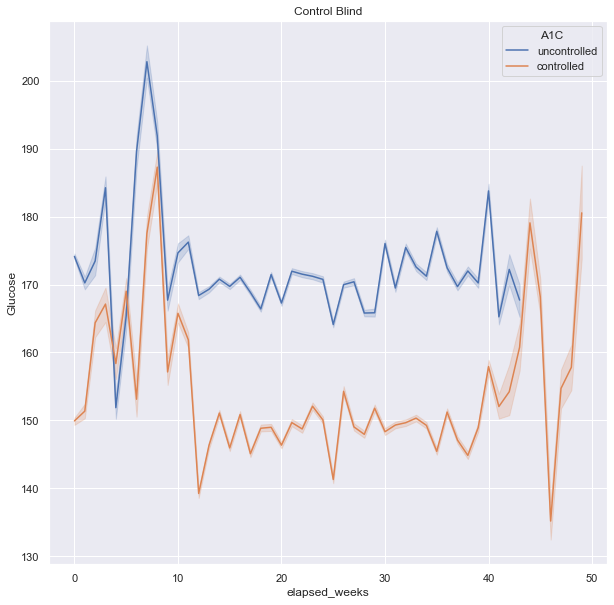

In [16]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(data=ctrl_a1c, x='elapsed_weeks', y='Glucose', hue='A1C').set(title='Control Blind')

[Text(0.5, 1.0, 'Treatment Unblind')]

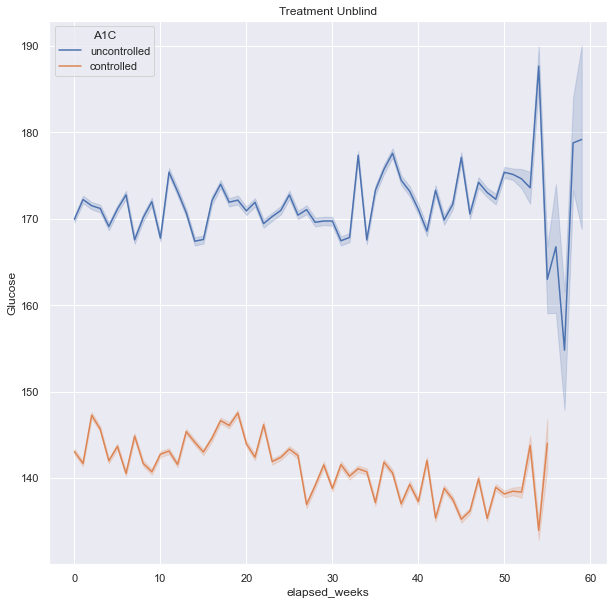

In [17]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(data=trmt_a1c, x='elapsed_weeks', y='Glucose', hue='A1C').set(title='Treatment Unblind')

In [19]:
def bmiClass(bmi):
    """
    Accepts dataframe 
    Returns dataframe with BMI column
    """
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'healthy_weight'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

def addBMICol(df):
    df['bmi'] = df.apply(lambda x: x['Weight'] / (x['Height']/100)**2, axis=1)
    df['bmi_class'] = df.apply(lambda x: bmiClass(x['bmi']), axis=1)
    df = df.drop(columns=['bmi'])
    return df

ctrl_bmi = addBMICol(ctrl_a1c)
trmt_bmi = addBMICol(ctrl_a1c)
    
ctrl_bmi.columns

Index(['RecID_x', 'PtID', 'DeviceDtTm', 'Glucose', 'RecID_y', 'Gender',
       'AgeAsOfRandDt', 'Race', 'Ethnicity', 'Height', 'Weight', 'DurDiabetes',
       'InsulinModality', 'NumSevHypo', 'HGMReadAvg', 'EduCareGvrP',
       'EduCareGvrPEdu', 'RandDt', 'TxGroup', 'pt_start_dt', 'elapsed_weeks',
       'Visit', 'LabA1cResult', 'A1C', 'bmi_class'],
      dtype='object')

[Text(0.5, 1.0, 'Treatment Group')]

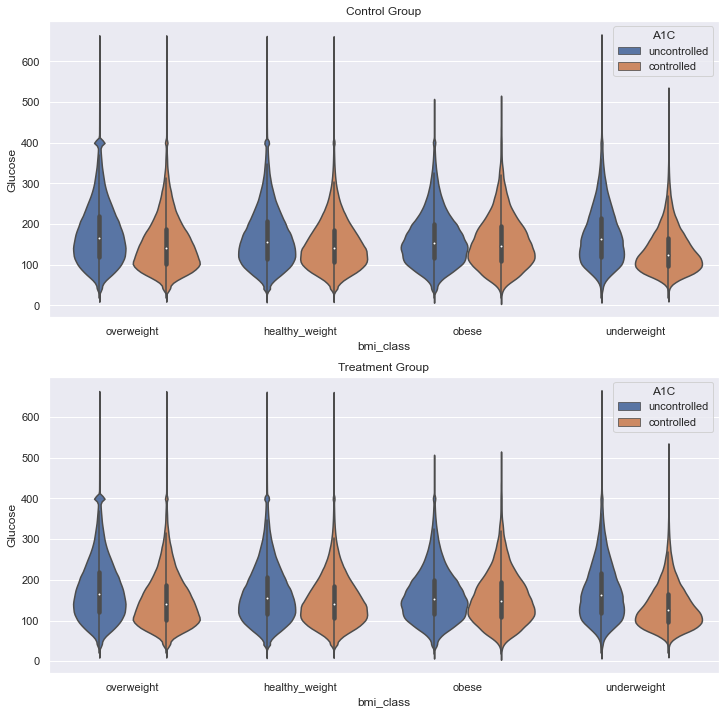

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.violinplot(x="bmi_class", y="Glucose", data=ctrl_bmi, hue='A1C', ax=ax[0]).set(title='Control Group')
sns.violinplot(x="bmi_class", y="Glucose", data=trmt_bmi, hue='A1C', ax=ax[1]).set(title='Treatment Group')

In [ ]:
# Adds time of day column
# def hour2time(hour):
#     if hour < 6:
#         return 'night'
#     elif hour < 12:
#         return 'morning'
#     elif hour < 18:
#         return 'afternoon'
#     else:
#         return 'evening'
    
# def dt2TimeOfDay(df):
#     df['time_of_day'] = df.apply(lambda x: hour2time(x['DeviceDtTm'].hour) , axis=1)
#     return df

# ctrl_blind_df = dt2TimeOfDay(ctrl_blind_df)
# ctrl_unblind_df = dt2TimeOfDay(ctrl_unblind_df)
# trmt_unblind_df = dt2TimeOfDay(trmt_unblind_df)

In [ ]:
# # Adds day of the week column
# def addDay(df):
#     df['day'] = df.DeviceDtTm.dt.day_name()
#     return df

# ctrl_blind_df = addDay(ctrl_blind_df)
# ctrl_unblind_df = addDay(ctrl_unblind_df)
# trmt_unblind_df = addDay(trmt_unblind_df)